In [1]:
from data import *
from vf import *

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import lightning as pl
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import random


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
train_traj, test_traj = get_dataset(sdt=['rotationRate'], act_labels=['jog'])

[INFO] -- Selected sensor data types: ['rotationRate']
[INFO] -- Selected activites: ['jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(134231, 10)


In [2]:
class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, max_horizon=100):
        self.data = dataframe
        self.trajectories = []
        self.max_horizon = max_horizon
        self.feature_columns = dataframe.columns.difference(['exact_id', 'timeidx']).tolist()
        
        for exact_id, group in self.data.groupby('exact_id'):
            group_sorted = group.sort_values('timeidx')
            full_traj = group_sorted[self.feature_columns].values.astype(float)
        
            n_segments = len(full_traj) // self.max_horizon
            for i in range(n_segments):
                start_idx = i * self.max_horizon
                end_idx = start_idx + self.max_horizon
                segment = full_traj[start_idx:end_idx]
                self.trajectories.append(segment)

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.trajectories[idx])

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Папка для сохранения
    filename="best_model_{epoch}_{train_loss:.2f}",  # Шаблон имени файла
    monitor="train_loss",  # Метрика для мониторинга
    mode="min",  # Сохранять при минимальном значении метрики
    save_top_k=3,  # Сохранять 3 лучшие модели
    every_n_epochs=1,  # Сохранять каждую эпоху
    save_weights_only=True  # Сохранять только веса
)

train_dataset = TrajectoryDataset(train_traj)
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

# Инициализация модели
model = DynamicSystemLearner(dt=0.01, lr=1e-1)

# Настройка логгера
logger = pl.pytorch.loggers.TensorBoardLogger(
    save_dir="logs",
    name="dynamic_system",
    version=f"experiment_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
)

# Конфигурация тренера
trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    accelerator="auto",
    enable_progress_bar=True,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback]
)

# Запуск обучения
trainer.fit(model, dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ivan/Python/m1p/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ivan/Documents/HW/2025-Project-186/experiments/accelerometr/checkpoints exists and is not empty.

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | vf        | NodeField | 1.2 K  | train
1 | criterion | L1Loss    | 0      | train
------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

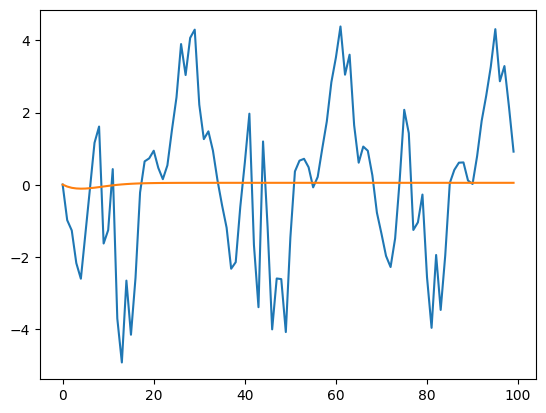

In [15]:
plt.plot(np.arange(len(X[:, 0])), X[:, 0])


X_pred = model(X0, t)

plt.plot(np.arange(len(X_pred[:, 0].detach().numpy())), X_pred[:, 0].detach().numpy())

plt.show()